# Necessary Imports and loading dataset

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import random

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

import gensim
from gensim.models import Word2Vec

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

dataset = pd.read_csv('cleaned.csv')
dataset.dropna()
dataset.shape

[nltk_data] Downloading package stopwords to /home/rupesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rupesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(413, 3)

# Exploratory Data Analysis


In [3]:
#number of rows and columns in dataset
rows, col = dataset.shape
print(f"The dataset have {rows} rows and {col} columns")

The dataset have 413 rows and 3 columns


In [4]:
#number of artists the data is collected from
number_of_artists = dataset['Artist'].nunique()
print(f"The dataset has been collected from {number_of_artists} different artists")

The dataset has been collected from 62 different artists


In [5]:
#all column names
dataset.columns

Index(['Artist', 'Song Title', 'Lyrics'], dtype='object')

In [6]:
#checking for duplicate values
dataset.duplicated().any()

False

In [7]:
#checking for null values
dataset.isna().any()

Artist        False
Song Title    False
Lyrics        False
dtype: bool

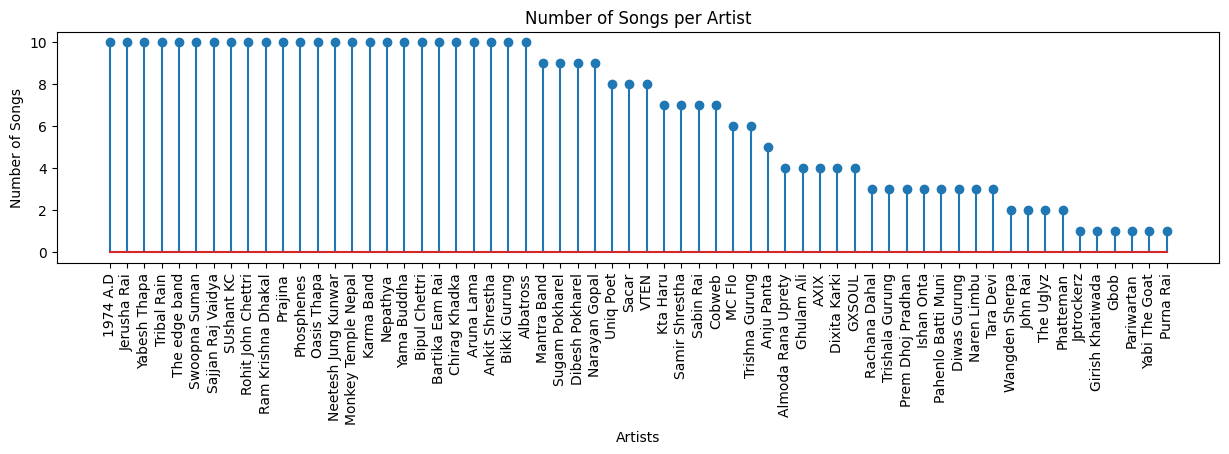

In [8]:
# Count the number of songs per artist and sort them
music_count_by_artist = dataset.groupby(by="Artist").count()["Song Title"]
music_count_by_artist = music_count_by_artist.sort_values(ascending=False)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,3))

# Plot the stem plot
ax.stem(range(len(music_count_by_artist)), music_count_by_artist.values)

# Set the x-ticks to artist names
ax.set_xticks(range(len(music_count_by_artist)))
ax.set_xticklabels(music_count_by_artist.index, rotation=90)

# Set labels and title
plt.xlabel("Artists")
plt.ylabel("Number of Songs")
plt.title("Number of Songs per Artist")

# Show the plot
plt.show()


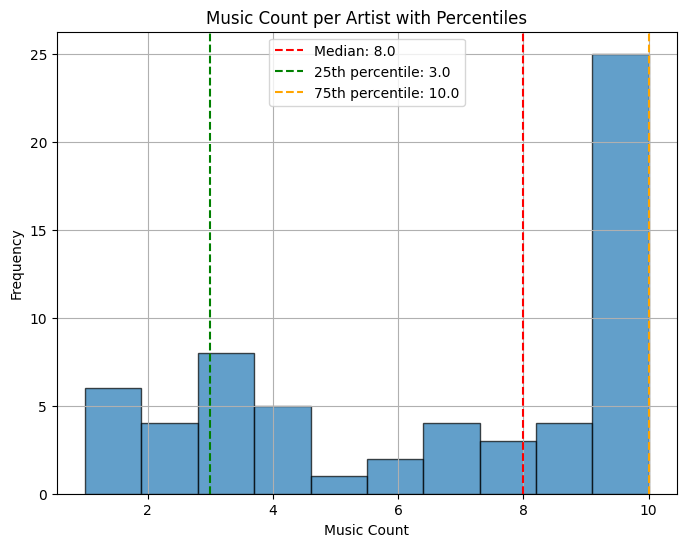

In [9]:
# some statistics for music per artists

val = music_count_by_artist.values

mean = val.mean()
std = val.std()
median = np.median(val)
percentiles = np.percentile(val, [25, 50, 75])

# Plot histogram of the values with percentiles
plt.figure(figsize=(8, 6))
plt.hist(val, bins=10, edgecolor='black', alpha=0.7)
plt.axvline(median, color='r', linestyle='--', label=f'Median: {median}')
plt.axvline(percentiles[0], color='g', linestyle='--', label=f'25th percentile: {percentiles[0]}')
# plt.axvline(percentiles[1], color='b', linestyle='--', label=f'50th percentile: {percentiles[1]}')
plt.axvline(percentiles[2], color='orange', linestyle='--', label=f'75th percentile: {percentiles[2]}')
plt.title('Music Count per Artist with Percentiles')
plt.xlabel('Music Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()



# Data Cleaning and Preprocessing

#### lets sample few random lyrics and try to find some common occuring patterh

In [10]:
sample_lyrics = dataset["Lyrics"].tolist()
sample_lyrics = random.choices(sample_lyrics, k=5)

In [11]:
sample_lyrics

['1 ContributorTranslationsRomanizationSamjhana Lyrics[Verse 1]\nआँखा जस्तै मन छ भारी\nसम्झना सबै समाली राखी\nजाँदै छु म टाढा कतै\nबिर्सन दिनु मलाई है\n\n[Chorus]\nबिर्सनुलाइ\u2005गारो\u2005छैन\nसम्हाली राख सम्झना\nकस्तो\u2005समय र परिस्थिति\nतिम्रो र मेरो भाग्य\u2005जस्तै\nसम्झिनेलाइ सम्झना बिर्सनेलाई बिर्सना\n\n{Verse 2]\nतिमी नै मेरो साहारा हौ\nतिमी नै मेरो रहर हौ\nतिमी बाहेक अरु कसले मलाई बुझ्न् सक्छर\nतिमी बिनाको जिन्दगी खै केको जिन्दगी\nटाढा हुनु, डर लाग्छ बिर्सन दिनु मलाई है\n\n[Chorus]\nबिर्सनुलाइ गारो छैन\nसम्हाली राख सम्झना\nकस्तो समय र परिस्थिति?\nतिम्रो र मेरो भाग्य जस्तै\nसम्झिनेलाइ सम्झना बिर्सनेलाई बिर्सनाYou might also likeEmbed',
 '1 ContributorGauthali Lyricsमसँगै उड न गौँथली\nटाढा-नजिक जहाँ भए नि\nमसँगै उड न गौँथली\nटाढा नजिक जहाँ भए नि\n\nएकैछिन गर न चिर्\u200cबिरी\nके होला तिम्रो त्यो मनभरी\n\nयो घर, न तिम्रो न मेरो\nयो घर, न तिम्रो न मेरो\nबाटो लाग्\u200dनै पर्\u200dयो\nबाटो लाग्\u200dनै पर्\u200dयो\n\nअल्झिएका कतै हामी दुबै\nतिमी न्यानो भन्दै, म माया भन्दै\nएकै ठ

#### The common pattern here is that the lyrics are line seperated. There are some information about contributors, the title of the song and the structure information about the song such as Chorus, verse, bridge, Intro and Outtro. We will create a function to remove the unnecessary words from the lyrics.

#### Also, non-lexical vocable such as (ओ, हो,um ,mmm,ooh,रे,ग,र,म,प etc ) are used in songs to improve vocals and tone 

In [12]:
#removing contributor information and words like [Intro], [Outro], [Chorus]

# Function to clean unnecessary words including contributor info
def remove_unnecessary_words(lyrics):
    import re
    # Define patterns of words/phrases to be removed

    unnecessary_patterns = [
        r"\d+ Contributor.*yrics", #removes contributor information 
        r"\[.*?\]", #removes anything between []
        r'[,\?:)(&_\-\.]', #removes punctuations
        r"You might also likeEmbed",
        r"You might also like",
        r"Embed"    
    ]
    # Join the patterns into a single regex
    combined_pattern = "|".join(unnecessary_patterns)
    
    # Use re.sub to remove matching patterns from the lyrics
    cleaned_lyrics = re.sub(combined_pattern, ' ', lyrics, flags=re.MULTILINE)
    
    # Return the cleaned lyrics, also removing extra spaces/newlines
    return cleaned_lyrics.replace('\n', ' ')



def load_stopwords():
    # Load custom Nepali stop words from the file
    with open('stop_words.txt', 'r', encoding='utf-8') as f:
        stop_words = set(line.strip() for line in f.readlines())

    # Load English stop words from NLTK
    english_stopwords = set(stopwords.words('english'))
    
    # Combine both sets of stop words
    combined_stop_words = stop_words.union(english_stopwords)
    return combined_stop_words

def remove_stopwords(text):
    stop_words = load_stopwords()
    text = [word for word in text.lower().split() if word not in stop_words]
    return ' '.join(text)




In [13]:
dataset["Lyrics"] = dataset["Lyrics"].apply(
    lambda X: remove_unnecessary_words(X)).apply(
    lambda X: remove_stopwords(X)
)


In [14]:

#lets try to visualize what the processed text look like
sample_lyrics = dataset["Lyrics"].tolist()
sample_lyrics = random.choices(sample_lyrics, k=5)
sample_lyrics


["underwater look answers never seem find ocean another man dying inside waters whisper cannot understand maybe word help figure underwater there's place hide forever take hand i'll show way tell never return waters whisper cannot understand maybe word help figure dance together underwater sing sweet melodies knew underwater underwater haa woah underwater underwater haa woah underwater underwater haa woah underwater underwater haa woah underwater underwater haa woah day come sure let go far away i'll underwater",
 "mandem wanna talk shit never listen perfect definition fool ruler yama buddha rudest always end winning lose mad temper can’t read tracks cd like bad sector i’m deep like lazy bring heat like crazy beat like baby mother’s life wrecked poor shots bad director hope dope could never cope pressure i’m bringing back crack rap resurrector allow it! i’m fresher it’s break bones go home stretcher yes sir! that’s coming straight outta kathmandu think risk don’t get twisted y'all pigs

In [15]:
load_stopwords()

{'',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ah',
 'ahh',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'ayy',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'ha',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'hm',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mhh',
 'mightn',
 "mightn't",
 'mm',
 'mmm',
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'oh',
 'on',
 'once',
 'only',
 'oo

In [16]:
dataset.iloc[319]["Lyrics"]

"yes yes top check wagwan people world right boy lil buddha coming one song bring us together one song talk love peace need world right come ride along x4 one nation discrimination welcome y'all ganja nation smoke joint comes morning smoke joint comes night roll smoke pass babe makes us feel right government please listen needs got legalize cause stanza inhales puff ganja enlightens eyes yes! say there's hate side light lighter hop flight see love see peace really relaxing travel space gotta smoke joint comes morning smoke joint comes night roll smoke pass babe makes us feel right government please listen needs got legalize cause stanza inhales puff ganja enlightens mind yes! say there's hate side light lighter hop flight see love see peace really relaxing travel space till infinity fiddle lsd mix thc capitalism sickness beat marijuana medicine x4 one nation discrimination welcome y'all ganja nation bole bole bum bum roll roll son tokin' chronic smoke openinh tongue magical herb help m

# Word Embedding and Vectorization

In [17]:
corpus = dataset["Lyrics"].values

In [18]:
# Tokenizing the lyrics
tokenized_lyrics = [lyrics.lower().split() for lyrics in corpus]

In [19]:
# Train the Word2Vec model
model = Word2Vec(sentences=tokenized_lyrics, vector_size=50, window=2, min_count=1, sg=0)

# Save the model for later use
model.save("word2vec_lyrics.model")


In [20]:
# Load the model
model = Word2Vec.load("word2vec_lyrics.model")

# Get the vector for a specific word
vector = model.wv['जीवन']

# Find most similar words
similar_words = model.wv.most_similar('केश', topn=5)

print("Vector for 'love':", vector)
print("Most similar words to 'love':", similar_words)


Vector for 'love': [-0.03458777 -0.041856   -0.06319106  0.01192335 -0.10658211 -0.19042313
  0.24836414  0.37996882 -0.32766518 -0.11906631 -0.09213616 -0.22087157
  0.12379912  0.10581231 -0.21262243  0.14138837  0.16152593  0.00259165
 -0.28374663 -0.258562    0.03996619  0.12647928  0.40524238 -0.06917597
  0.08717941 -0.02108686 -0.07071334  0.02791406 -0.24609353  0.02680659
  0.07457289 -0.10946081 -0.06179933 -0.04172801 -0.09184437  0.13715205
  0.15036066  0.04957563  0.06996333 -0.13308464  0.23078847 -0.0254045
 -0.04559314  0.14882658  0.5176508   0.01106489 -0.1381025  -0.19919282
  0.09334535  0.08265876]
Most similar words to 'love': [('खालि', 0.8838631510734558), ('छन', 0.8834099769592285), ('हुन्न', 0.8819722533226013), ('छोडी', 0.8753207921981812), ('आगो', 0.8739381432533264)]


## Clustering the lyrics into different categories using KMeans

In [32]:
from sklearn.cluster import KMeans
import numpy as np

# Function to compute the average embedding for each lyric
def average_embedding(text):
    tokens = set(text.lower().split())
    embeddings = []
    for token in tokens:
        if token in model.wv:  # Check if token exists in the Word2Vec vocabulary
            embedding = model.wv[token]
            embeddings.append(embedding)
    
    if embeddings:  # Calculate average embedding
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no embeddings found

# Apply the average_embedding function to each lyric
dataset['Embedding'] = dataset['Lyrics'].apply(average_embedding)


In [33]:
np.array(dataset["Embedding"]).shape

(413,)

In [38]:
# Extract the embeddings from the dataframe
X = np.vstack(dataset['Embedding'].values)  # Create a matrix of embeddings

# Specify the number of clusters
num_clusters = 5# You can change the number of clusters based on your requirement

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign clusters to the lyrics
dataset['Cluster'] = kmeans.labels_


In [39]:
print(dataset[['Lyrics', 'Cluster']].head())


                                              Lyrics  Cluster
0  पानी पऱ्यो सरर छाना बज्यो गरर मनमा उठ्यो आज मे...        2
1  डढेलो लाग्यो त्यो पारि डाँडा साँझतिर लौ है फेर...        0
2  गहिरो गहिरो जीवन सागर यो तरि नै रहेछु बगिरहेको...        3
3  ईन्द्रेनि रङ्गको छ तिम्रो निर्मल संसार कमलको फ...        1
4  राम साइली त यौवनको पिरले गम खाए यसै खोला किनार...        0


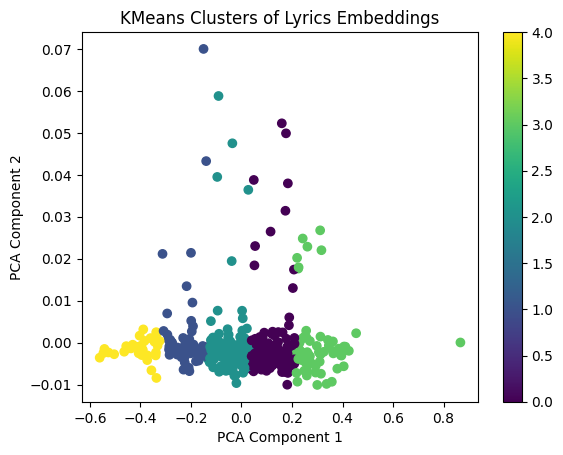

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('KMeans Clusters of Lyrics Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


/tmp/ipykernel_30097/105891704.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_artist_pca[:, 0], X_artist_pca[:, 1],
/tmp/ipykernel_30097/105891704.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


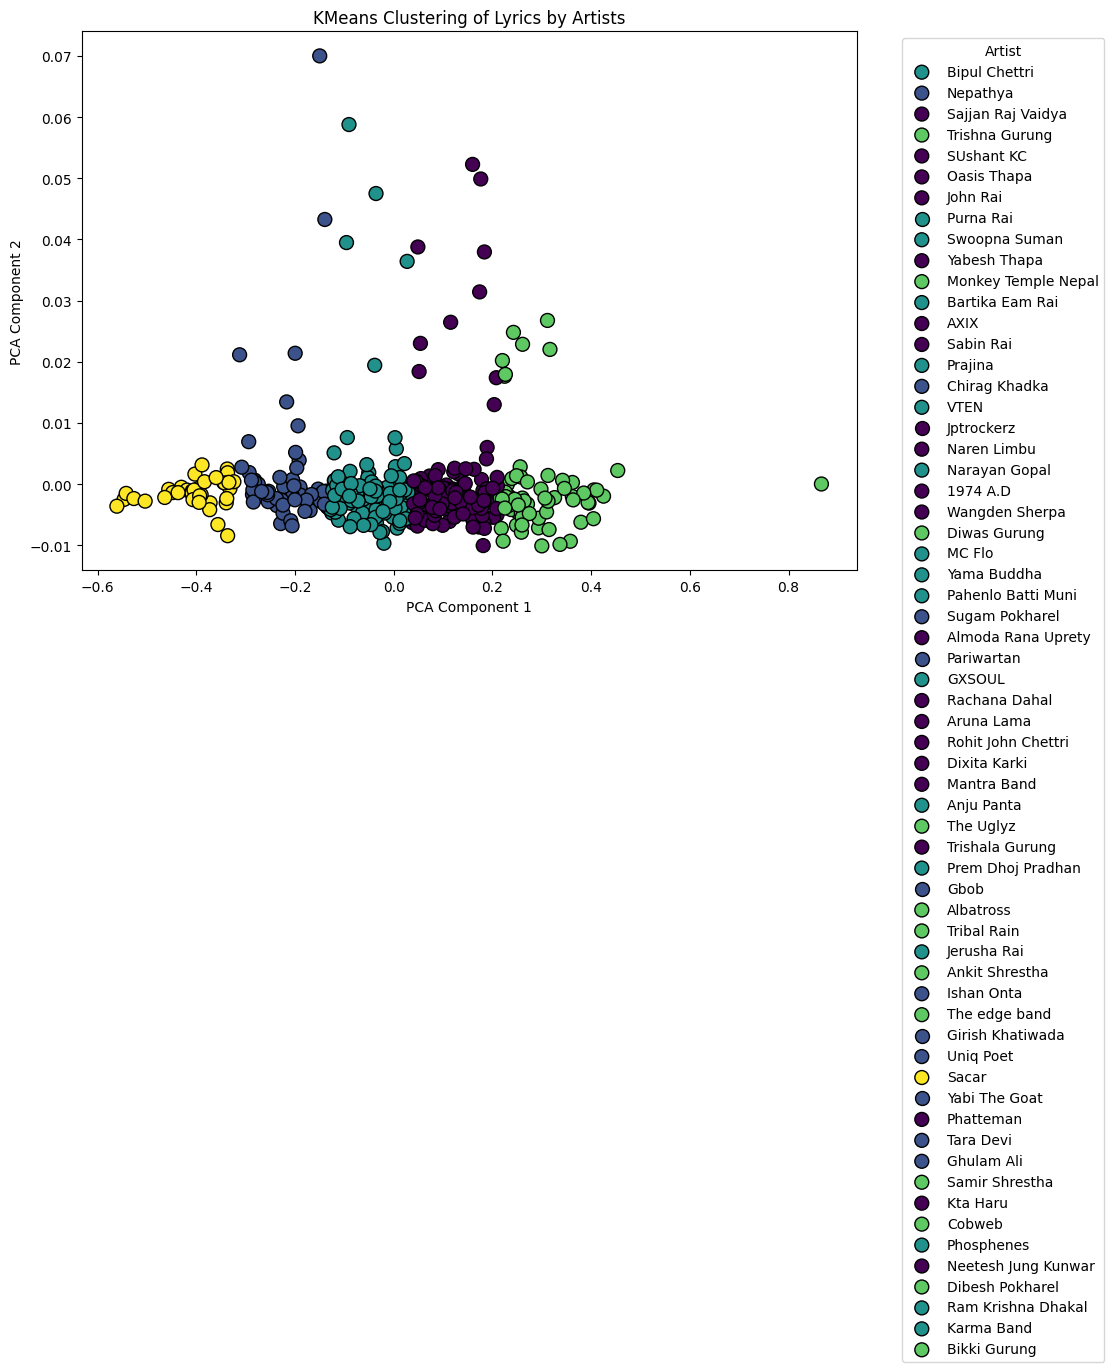

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce embeddings to 2D for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a color map for the clusters
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))

# Create a plot
plt.figure(figsize=(10, 7))

# Scatter plot for each artist
artists = dataset['Artist'].unique()

for artist in artists:
    artist_data = dataset[dataset['Artist'] == artist]
    X_artist_pca = X_pca[artist_data.index]
    
    # Plot each artist with a different marker
    plt.scatter(X_artist_pca[:, 0], X_artist_pca[:, 1], 
                label=artist, c=colors[artist_data['Cluster']], 
                cmap='viridis', edgecolor='k', s=100)

# Add title, labels, and legend
plt.title('KMeans Clustering of Lyrics by Artists')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Artist', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [31]:
dataset[dataset["Cluster"] == 6]["Artist"].unique()

array(['Bipul Chettri', 'Sajjan Raj Vaidya', 'Trishna Gurung',
       'SUshant KC', 'Oasis Thapa', 'Swoopna Suman', 'Yabesh Thapa',
       'Monkey Temple Nepal', 'Bartika Eam Rai', 'AXIX', 'Sabin Rai',
       'Prajina', 'Naren Limbu', 'Wangden Sherpa', 'Diwas Gurung',
       'Pahenlo Batti Muni', 'Sugam Pokharel', 'Rohit John Chettri',
       'Dixita Karki', 'Mantra Band', 'Anju Panta', 'The Uglyz',
       'Trishala Gurung', 'Albatross', 'Tribal Rain', 'Ankit Shrestha',
       'The edge band', 'Samir Shrestha', 'Kta Haru', 'Cobweb',
       'Phosphenes', 'Karma Band', 'Bikki Gurung'], dtype=object)